# Dust Detection from Remote Sensing Images
In this notebook input images are used from MODIS Terra satellite from NASA. Here one sample .hdf file is used for input.
There is one data folder where the .hdf file is located. That file is downloaded from NASA LAADS DAAC.

##### All the Necessary packages and libraries are loaded

In [59]:
from scipy.signal import cspline2d

import imageio as img
import cv2
from PIL import Image
from skimage import io


import matplotlib.pyplot as plt

from satpy import Scene, MultiScene, available_readers, available_writers, find_files_and_readers
from satpy.readers import modis_l1b, modis_l2
from satpy.writers import get_enhanced_image
from satpy.composites import GenericCompositor

import numpy as np
import pandas as pd
from pyresample import geometry

import os
import warnings

import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep

from datetime import datetime

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array, load_img

import tensorflow as tf
# import statements
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import datasets, transforms, models
import argparse
from tqdm import tqdm
import time
import torchvision

from tensorboardX import SummaryWriter

# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler

# from utils import load_checkpoint, save_checkpoint, ensure_dir
# from model import MyModel

## Module 1: Remote Sensing MODIS Data
##### Checking the directory to find the location of data

In [2]:
#####################
# LOADING DATASET
#####################

def content_from_path(path):
    return os.listdir(path)

def generate_data_from_path(path):
    images = []
    dataset_path = content_from_path(path)
    
    for item in dataset_path:
        images.append(item)
        
    return images
     
def generate_data_from_folder():
    images = []
    
    for item in dataset_path:
        path = 'nasa' + '/' + item
        if os.path.isdir(path):  
            image = os.listdir(path)
            images.append(str(path + '/' + image[0]))
    return images

In [21]:
#####################
# MAKING DATAFRAME
#####################

images = generate_data_from_path('nasa-calibrated-resize');
dust_df = pd.DataFrame(data=images, columns=["image"])
dust_df

,image
0,A2005099.1730.tc1km.jpg
1,A2006071.1810.tc1km.jpg
2,A2012071.1055.tc1km.jpg
3,A2012062.1735.tc1km.jpg
4,A2013185.1735.tc1km.jpg
...,...
111,A2012291.1750.tc1km.jpg
112,A2003086.1820.tc1km.jpg
113,A2012292.2015.tc1km.jpg
114,A2002351.1845.tc1km.jpg


In [22]:
##################################################
# MAKING HORIZONTAL SPLITTED DATASET
##################################################

counter = 0
for item in dust_df['image']:
    
    input_path = "nasa-calibrated-resize/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    outputPath = "horizontal/"
    
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    x_width, y_height = im.size
    # print(x_width, y_height)
    
    outputFileFormat = "{0}-{1}.jpg"
    baseName = "cropped"
    
    split = 10
    edges = np.linspace(0, x_width, split + 1)
    # print(edges)
    # print(edges[:-1])
    # print(edges[1:])
    for start, end in zip(edges[:-1], edges[1:]):
        box = (start, 0, end, y_height)
        a = im.crop(box)
        x_width, y_height = a.size
        # print(x_width, y_height)
        a.load()
        outputName = os.path.join(outputPath, outputFileFormat.format(item.removesuffix(".jpg"), counter + 1))
        counter = counter + 1
        # print(outputName)
        a.save(outputName, "JPEG")
        
horizontal_images = generate_data_from_path('horizontal');
dust_df_horizontal = pd.DataFrame(data=horizontal_images, columns=["image"])
dust_df_horizontal

,image
0,A2001164.0950.tc1km-191.jpg
1,A2012105.2030.tc1km-983.jpg
2,A2012292.1835.tc1km-1000.jpg
3,A2013051.1805.tc1km-567.jpg
4,A2003105.1715.tc1km-685.jpg
...,...
1156,A2012064.0735.tc1km-71.jpg
1157,A2012293.1740.tc1km-234.jpg
1158,A2011334.1940.tc1km-121.jpg
1159,A2012145.1805.tc1km-254.jpg


In [23]:
for item in dust_df_horizontal['image']:
    
    input_path = "horizontal/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    # im.show()
    x_width, y_height = im.size
    # print(x_width, y_height)
    # print(img.shape)
    # print(input_path)
    if x_width != 128:
        print(input_path)
        os.remove(input_path)
    # break

In [25]:
##################################################
# MAKING VERTICAL SPLITTED DATASET
##################################################

counter = 0
for item in dust_df_horizontal['image']:
    
    input_path = "horizontal/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    outputPath = "horizontal/final"
    
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    x_width, y_height = im.size
    # print(x_width, y_height)
    
    outputFileFormat = "{0}-{1}.jpg"
    baseName = "cropped"
    
    split = 15
    edges = np.linspace(0, y_height, split + 1)
    # print(edges)
    # print(edges[:-1])
    # print(edges[1:])
    for start, end in zip(edges[:-1], edges[1:]):
        box = (0, start, x_width, end)
        a = im.crop(box)
        a.load()
        outputName = os.path.join(outputPath, outputFileFormat.format(item.removesuffix(".jpg"), counter + 1))
        counter = counter + 1
        # print(outputName)
        a.save(outputName, "JPEG")
        
final_images = generate_data_from_path('horizontal/final');
dust_df_final = pd.DataFrame(data=final_images, columns=["image"])
dust_df_final

,image
0,A2011306.2055.tc1km-443-6556.jpg
1,A2003113.1800.tc1km-978-1284.jpg
2,A2011309.1815.tc1km-898-3123.jpg
3,A2012291.1755.tc1km-143-16873.jpg
4,A2009156.0750.tc1km-1106-16655.jpg
...,...
17395,A2012037.1110.tc1km-581-12632.jpg
17396,A2012145.1805.tc1km-257-16214.jpg
17397,A2012105.1720.tc1km-363-14359.jpg
17398,A2011335.1850.tc1km-311-11420.jpg


In [26]:
for item in dust_df_final['image']:
    
    input_path = "horizontal/final/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    count = 1
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    # im.show()
    x_width, y_height = im.size
    # print(x_width, y_height)
    # print(item.index)
    if y_height != 128:
        print(img.shape)
        os.remove(input_path)
    # break

In [27]:
##########################################
# MAKING FINAL DATAFRAME
##########################################

images = generate_data_from_path('horizontal/final/');
dust_df_final_calibrated = pd.DataFrame(data=images, columns=["image"])
dust_df_final_calibrated

,image
0,A2011306.2055.tc1km-443-6556.jpg
1,A2003113.1800.tc1km-978-1284.jpg
2,A2011309.1815.tc1km-898-3123.jpg
3,A2012291.1755.tc1km-143-16873.jpg
4,A2009156.0750.tc1km-1106-16655.jpg
...,...
17395,A2012037.1110.tc1km-581-12632.jpg
17396,A2012145.1805.tc1km-257-16214.jpg
17397,A2012105.1720.tc1km-363-14359.jpg
17398,A2011335.1850.tc1km-311-11420.jpg


In [29]:
for item in dust_df_final_calibrated['image']:
    
    input_path = "horizontal/final/" + item
    if input_path.endswith('DS_Store') or os.path.isdir(input_path):
        continue
    count = 1
    img = cv2.imread(input_path)
    im = Image.open(input_path)
    # im.show()
    x_width, y_height = im.size
    # print(x_width, y_height)

In [62]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [ ]:
class DustDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        # print(img_path)
        if self.transform:
            image = self.transform(image)

        return (image, y_label)

Image batch dimensions: torch.Size([32, 3, 128, 128])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])
Fold 1
Epoch: 001/010 | Batch 0000/0014 | Loss: 0.6892
Epoch: 001/010 | Train: 94.43% | Validation: 75.76%
Time elapsed: 0.28 min
Epoch: 002/010 | Batch 0000/0014 | Loss: 0.3761
Epoch: 002/010 | Train: 94.43% | Validation: 75.76%
Time elapsed: 0.56 min
Epoch: 003/010 | Batch 0000/0014 | Loss: 0.2400
Epoch: 003/010 | Train: 94.43% | Validation: 75.76%
Time elapsed: 0.84 min
Epoch: 004/010 | Batch 0000/0014 | Loss: 0.1845
Epoch: 004/010 | Train: 94.43% | Validation: 75.76%
Time elapsed: 1.12 min
Epoch: 005/010 | Batch 0000/0014 | Loss: 0.1703
Epoch: 005/010 | Train: 94.43% | Validation: 75.76%
Time elapsed: 1.40 min
Epoch: 006/010 | Batch 0000/0014 | Loss: 0.0254
Epoch: 006/010 | Train: 94.43% | Validation: 75.76%
Time elapsed: 1.68 min
Epoch: 007/010 | Batch 0000/0014 | Loss: 0.2506
Epoch: 007/010 | Train: 94.43% | Validation:

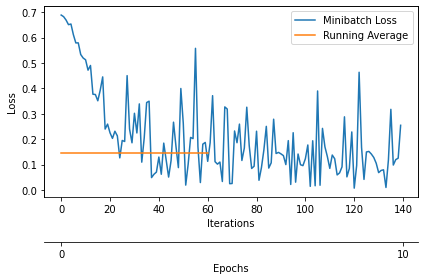

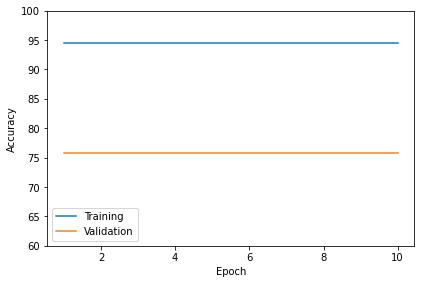

Fold 2
Epoch: 001/010 | Batch 0000/0014 | Loss: 0.6848
Epoch: 001/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 0.28 min
Epoch: 002/010 | Batch 0000/0014 | Loss: 0.4314
Epoch: 002/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 0.56 min
Epoch: 003/010 | Batch 0000/0014 | Loss: 0.2006
Epoch: 003/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 0.84 min
Epoch: 004/010 | Batch 0000/0014 | Loss: 0.1234
Epoch: 004/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 1.12 min
Epoch: 005/010 | Batch 0000/0014 | Loss: 0.0625
Epoch: 005/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 1.41 min
Epoch: 006/010 | Batch 0000/0014 | Loss: 0.0982
Epoch: 006/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 1.69 min
Epoch: 007/010 | Batch 0000/0014 | Loss: 0.1023
Epoch: 007/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 1.96 min
Epoch: 008/010 | Batch 0000/0014 | Loss: 0.1716
Epoch: 008/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 2.25 min
Epoch: 00

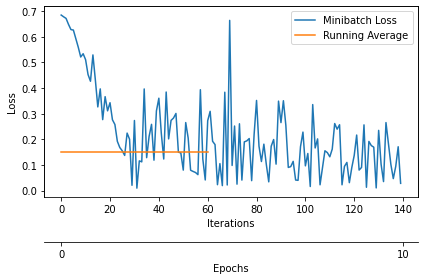

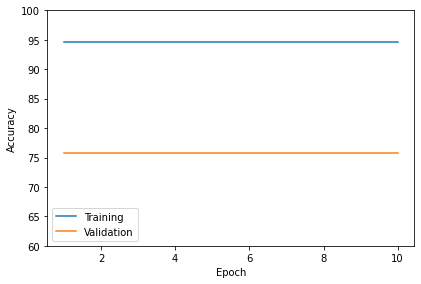

Fold 3
Epoch: 001/010 | Batch 0000/0014 | Loss: 0.6952
Epoch: 001/010 | Train: 95.36% | Validation: 75.76%
Time elapsed: 0.28 min
Epoch: 002/010 | Batch 0000/0014 | Loss: 0.4279
Epoch: 002/010 | Train: 95.36% | Validation: 75.76%
Time elapsed: 0.56 min
Epoch: 003/010 | Batch 0000/0014 | Loss: 0.1288
Epoch: 003/010 | Train: 95.36% | Validation: 75.76%
Time elapsed: 0.85 min
Epoch: 004/010 | Batch 0000/0014 | Loss: 0.1281
Epoch: 004/010 | Train: 95.36% | Validation: 75.76%
Time elapsed: 1.13 min
Epoch: 005/010 | Batch 0000/0014 | Loss: 0.1132
Epoch: 005/010 | Train: 95.36% | Validation: 75.76%
Time elapsed: 1.41 min
Epoch: 006/010 | Batch 0000/0014 | Loss: 0.2997
Epoch: 006/010 | Train: 95.36% | Validation: 75.76%
Time elapsed: 1.69 min
Epoch: 007/010 | Batch 0000/0014 | Loss: 0.0933
Epoch: 007/010 | Train: 95.36% | Validation: 75.76%
Time elapsed: 1.97 min
Epoch: 008/010 | Batch 0000/0014 | Loss: 0.2831
Epoch: 008/010 | Train: 95.36% | Validation: 75.76%
Time elapsed: 2.25 min
Epoch: 00

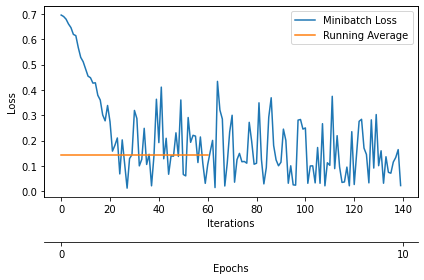

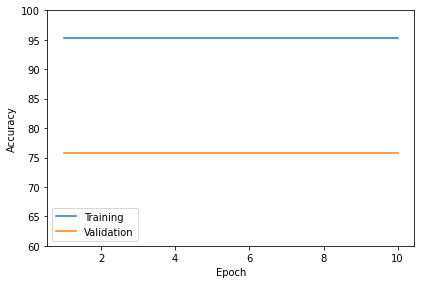

Fold 4
Epoch: 001/010 | Batch 0000/0014 | Loss: 0.6882
Epoch: 001/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 0.28 min
Epoch: 002/010 | Batch 0000/0014 | Loss: 0.3568
Epoch: 002/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 0.57 min
Epoch: 003/010 | Batch 0000/0014 | Loss: 0.2941
Epoch: 003/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 0.85 min
Epoch: 004/010 | Batch 0000/0014 | Loss: 0.0280
Epoch: 004/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 1.13 min
Epoch: 005/010 | Batch 0000/0014 | Loss: 0.1140
Epoch: 005/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 1.41 min
Epoch: 006/010 | Batch 0000/0014 | Loss: 0.1645
Epoch: 006/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 1.70 min
Epoch: 007/010 | Batch 0000/0014 | Loss: 0.1989
Epoch: 007/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 1.98 min
Epoch: 008/010 | Batch 0000/0014 | Loss: 0.2370
Epoch: 008/010 | Train: 94.66% | Validation: 75.76%
Time elapsed: 2.27 min
Epoch: 00

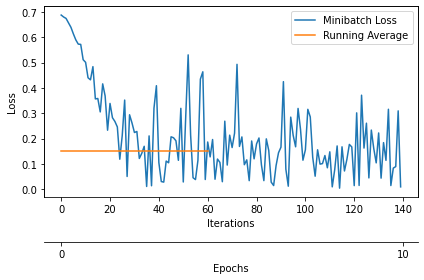

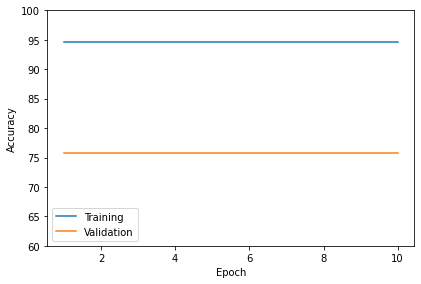

Fold 5
Epoch: 001/010 | Batch 0000/0014 | Loss: 0.6864
Epoch: 001/010 | Train: 94.91% | Validation: 75.76%
Time elapsed: 0.28 min
Epoch: 002/010 | Batch 0000/0014 | Loss: 0.3994
Epoch: 002/010 | Train: 94.91% | Validation: 75.76%
Time elapsed: 0.56 min
Epoch: 003/010 | Batch 0000/0014 | Loss: 0.1702
Epoch: 003/010 | Train: 94.91% | Validation: 75.76%
Time elapsed: 0.84 min
Epoch: 004/010 | Batch 0000/0014 | Loss: 0.2956
Epoch: 004/010 | Train: 94.91% | Validation: 75.76%
Time elapsed: 1.12 min
Epoch: 005/010 | Batch 0000/0014 | Loss: 0.1038
Epoch: 005/010 | Train: 94.91% | Validation: 75.76%
Time elapsed: 1.40 min
Epoch: 006/010 | Batch 0000/0014 | Loss: 0.1745
Epoch: 006/010 | Train: 94.91% | Validation: 75.76%
Time elapsed: 1.68 min
Epoch: 007/010 | Batch 0000/0014 | Loss: 0.0230
Epoch: 007/010 | Train: 94.91% | Validation: 75.76%
Time elapsed: 1.96 min
Epoch: 008/010 | Batch 0000/0014 | Loss: 0.2561
Epoch: 008/010 | Train: 94.91% | Validation: 75.76%
Time elapsed: 2.24 min
Epoch: 00

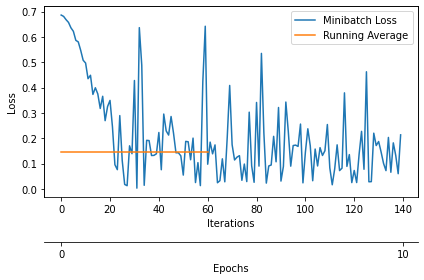

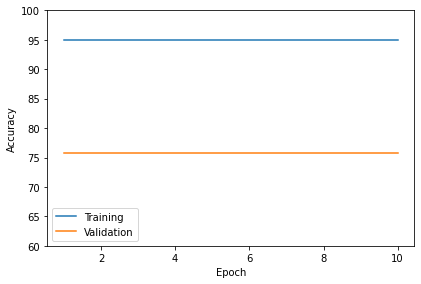

In [63]:
from sklearn.model_selection import StratifiedKFold, KFold

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([       
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cv = KFold(n_splits=5, random_state=123, shuffle=True)

# Load Data
dataset = DustDataset(
    csv_file="dataset.csv",
    root_dir="horizontal/dataset/",
    transform=train_transforms,
)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [440, 99, 100])
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

kv_dataset = ConcatDataset([train_set, valid_set])

# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break
    
for fold, (train_idx, val_idx) in enumerate(cv.split(kv_dataset)):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)
    
    model = AlexNetDust(num_classes=2)

    model = model.to(DEVICE)

    optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           factor=0.1,
                                                           mode='max',
                                                           verbose=True)

    minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
        model=model,
        num_epochs=NUM_EPOCHS,
        train_loader=train_loader,
        valid_loader=valid_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        device=DEVICE,
        scheduler=scheduler,
        scheduler_on='valid_acc',
        logging_interval=100)

    plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                       num_epochs=NUM_EPOCHS,
                       iter_per_epoch=len(train_loader),
                       results_dir=None,
                       averaging_iterations=200)
    plt.show()

    plot_accuracy(train_acc_list=train_acc_list,
                  valid_acc_list=valid_acc_list,
                  results_dir=None)
    plt.ylim([60, 100])
    plt.show()
    

#     history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

#     for epoch in range(num_epochs):
#         train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
#         test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

#         train_loss = train_loss / len(train_loader.sampler)
#         train_acc = train_correct / len(train_loader.sampler) * 100
#         test_loss = test_loss / len(test_loader.sampler)
#         test_acc = test_correct / len(test_loader.sampler) * 100

#         print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
#                                                                                                              num_epochs,
#                                                                                                              train_loss,
#                                                                                                              test_loss,
#                                                                                                              train_acc,
#                                                                                                              test_acc))
#         history['train_loss'].append(train_loss)
#         history['test_loss'].append(test_loss)
#         history['train_acc'].append(train_acc)
#         history['test_acc'].append(test_acc)

#     foldperf['fold{}'.format(fold+1)] = history

In [35]:
##########################
### FINAL DUST DATASET
##########################

# resize_transform = torchvision.transforms.Compose(
#     [torchvision.transforms.Resize((32, 32)),
#      torchvision.transforms.ToTensor(),
#      torchvision.transforms.Normalize((0.5,), (0.5,))])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([       
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load Data
dataset = DustDataset(
    csv_file="dataset.csv",
    root_dir="horizontal/dataset/",
    transform=train_transforms,
)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [440, 99, 100])



train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 128, 128])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])


In [45]:
class AlexNetDust(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

Epoch: 001/030 | Batch 0000/0015 | Loss: 0.6847
Epoch: 001/030 | Train: 87.76% | Validation: 90.00%
Time elapsed: 0.37 min
Epoch: 002/030 | Batch 0000/0015 | Loss: 0.5151
Epoch: 002/030 | Train: 87.76% | Validation: 90.00%
Time elapsed: 0.75 min
Epoch: 003/030 | Batch 0000/0015 | Loss: 0.1042
Epoch: 003/030 | Train: 87.76% | Validation: 90.00%
Time elapsed: 1.13 min
Epoch: 004/030 | Batch 0000/0015 | Loss: 0.1409
Epoch: 004/030 | Train: 87.76% | Validation: 90.00%
Time elapsed: 1.56 min
Epoch: 005/030 | Batch 0000/0015 | Loss: 0.5298
Epoch: 005/030 | Train: 87.76% | Validation: 90.00%
Time elapsed: 1.92 min
Epoch: 006/030 | Batch 0000/0015 | Loss: 0.3155
Epoch: 006/030 | Train: 87.76% | Validation: 90.00%
Time elapsed: 2.28 min
Epoch: 007/030 | Batch 0000/0015 | Loss: 0.1380
Epoch: 007/030 | Train: 87.76% | Validation: 90.00%
Time elapsed: 2.60 min
Epoch: 008/030 | Batch 0000/0015 | Loss: 0.3814
Epoch: 008/030 | Train: 87.76% | Validation: 90.00%
Time elapsed: 3.02 min
Epoch: 009/030 |

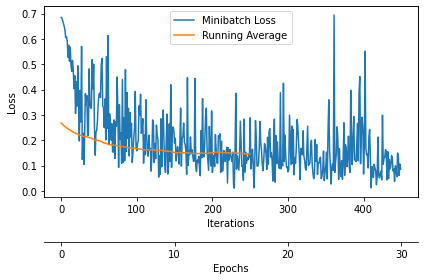

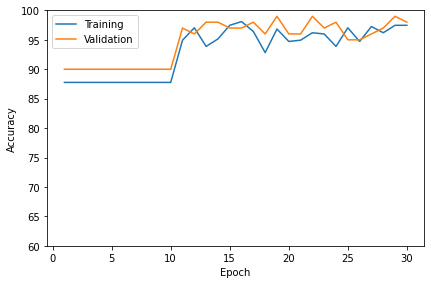

In [20]:
model = AlexNetDust(num_classes=2)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

##### Changing the folder to data to get access of the .hdf file
This file is downloaded before from NASA LAADS DAAC. Changing the directory should be executed only once otherwise it will show error because it has already changed the directory.


In [ ]:
# Set working directory to data to get access of the file
# os.chdir(os.path.join(os.getcwd(), 'data'))

# Accessing file for processing
filename = os.path.join("MOD021KM.A2021092.0020.006.2021092134055.hdf")
filenames = [filename]

##### Loading data to scene object from SatPy. 
SatPy is used here for processing remote sensing images
Printing available dataset names which is required for listing the bands
Here total 36 bands information are available

In [ ]:
# MODIS scene object using the file retrieved from data folder
modis_scene = Scene(reader='modis_l1b', filenames=filenames)
modis_scene.available_dataset_names()
# modis_scene.unload

##### Method: Band Details and Plotting
This is the custom method which takes band no and color map as parameter and shows all the necessary information about that particular band. The second method plot_band() takes the band no as parameter and plot the band.

In [ ]:
def band_details(band_no, cmap):
    
    print("Band no: ", band_no)
    print("Platform name: ", modis_scene[band_no].attrs['platform_name'])
    print("Dimension: ", modis_scene[band_no].dims)
    print("No of dimension: ", modis_scene[band_no].ndim)
    print("Wavelength: ", modis_scene[band_no].wavelength)
    print("Calibration: ", modis_scene[band_no].calibration)
    print("Maximum value: ", modis_scene[band_no].max().values)
    
    modis_scene[band_no].plot.imshow(cmap=cmap)
    plt.title("Band-{}".format(band_no))

def plot_band(band_no):

    plt.figure()
    modis_scene.load([band_no])
    band_details(band_no, 'cividis')
    modis_scene[band_no]

In [ ]:
band_no = '3'
plot_band(band_no)

### Data Extraction
Image data is extrcted from the metadata of MODIS hdf file

In [ ]:
data = modis_scene[band_no]
data

### Resizing Image
The dimension of input image is too high so the reduced dimension of image is used by resizing it to (128, 128) where original image dimension was (2030, 1354). Finally image value is normalized by dividing by 255. Image is first converted to matrix and then again to numpy array to match the dimension.

In [ ]:
iteration = 100

image = resize(img_to_array(modis_scene[band_no]), (128, 128),  mode = 'constant', preserve_range = True)
image = image/255.0
image.shape
image = np.matrix(image)
image = np.array(image)
image


In [ ]:
# Plotting the image after resizing
plt.figure()
plt.imshow(image, cmap = 'viridis')
plt.title('Band - ' + band_no)

In [ ]:
modis_scene.unload